In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import os
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from sklearn.preprocessing import MinMaxScaler

In [57]:
# !pip install cudatoolkit==11.4.0

ERROR: Could not find a version that satisfies the requirement cudatoolkit==11.4.0 (from versions: none)
ERROR: No matching distribution found for cudatoolkit==11.4.0


In [58]:
#initialize GPU -  In case of windows use cuda instead of nps
device = torch.device('cpu')

print("Is CUDA enabled?",torch.cuda.is_available())

Is CUDA enabled? False


In [59]:
class MLP(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(MLP, self).__init__()
        # Define the layers of the network
        self.fc1 = nn.Linear(T, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Define the forward pass
        x = F.tanh(self.fc1(x))  # Activation function (ReLU) after first layer
        x = F.tanh(self.fc2(x))  # Activation function (ReLU) after second layer
        x = self.fc3(x)          # Output layer
        return x
    
    
class RNN_floods(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(RNN_floods, self).__init__()
        # RNN layer
        self.rnn = nn.RNN(input_size=1, hidden_size=hidden_size, batch_first=True)

        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Reshape input to have feature dimension of 1
        x = x.unsqueeze(-1)   # Assuming input x has shape (batch, sequence)

        # RNN layer
        x, hn = self.rnn(x)   # We do not need the hidden states hn

        # Select the output of the last time step
        x = x[:, -1, :]

        # Output layer
        x = self.fc(x)

        return x

In [60]:
from simulation import Simulation

In [61]:
sim = Simulation.load_simulations("../data/processed_data/normalized_training_data", sim_amount=1, number_grids=64)[0]

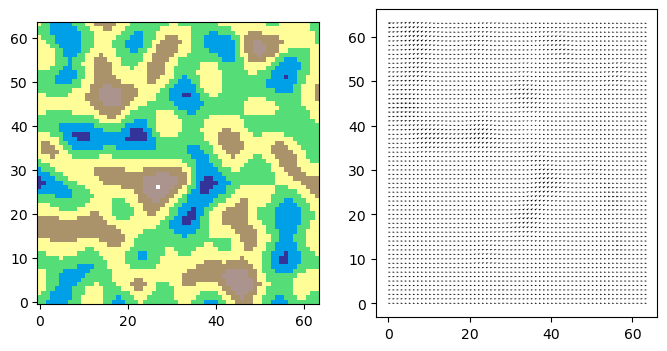

In [62]:
fig = sim.plot_vector(96)

In [63]:
X = np.zeros((96, 4096))
Y = np.zeros((96, 4096))

topography = sim.topography

for t_i in range(len(X)):
    wd, vx, vy = sim.return_timestep(t_i)
    X[t_i] = wd.reshape(-1)

    wd_vx_vy = sim.return_timestep(t_i+1)
    Y[t_i] = wd.reshape(-1)

training_size = 0.8
id_training = int(training_size * len(X))

X_tra = X[:id_training, :]
Y_tra = Y[:id_training, :]

X_val = X[id_training:, :]
Y_val = Y[id_training:, :]
# print(np.count_nonzero(X_tra[95]))
print(X_tra.shape)
print(Y_tra.shape)
print(X_val.shape)
print(Y_val.shape)

(76, 4096)
(76, 4096)
(20, 4096)
(20, 4096)


In [64]:
class SimpleRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        # RNN layer
        self.rnn = nn.RNN(input_size=1, hidden_size=hidden_size, batch_first=True, nonlinearity='relu')

        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Reshape input to have feature dimension of 1
        x = x.unsqueeze(-1)   # Assuming input x has shape (batch, sequence)

        # RNN layer
        x, hn = self.rnn(x)   # We do not need the hidden states hn

        # Select the output of the last time step
        x = x[:, -1, :]

        # Output layer
        x = self.fc(x)

        return x

In [76]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0

    with torch.no_grad():  # No need to track gradients during evaluation
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    return avg_test_loss


def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, save_path):
    best_val_loss = float("inf")  # Track the best validation loss
    train_losses = []
    val_losses = []

    start_time = time.time()  # Start training time

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        total_train_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation Phase
        avg_val_loss = evaluate_model(model, val_loader, criterion, device)
        val_losses.append(avg_val_loss)

        # Save Best Model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), save_path)

        if (epoch + 1) % 20 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}', f'Train Loss: {avg_train_loss:.4f}, '
                  f'Validation Loss: {avg_val_loss:.4f}', f'Best Validation Loss: {best_val_loss:.4f}')
    train_time = time.time() - start_time
    print("Training complete.")
    return train_losses, val_losses, best_val_loss, train_time

In [66]:
from torch.utils.data import TensorDataset, DataLoader

In [67]:

train_dataset = TensorDataset(torch.tensor(X_tra, dtype=torch.float32), torch.tensor(Y_tra, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(Y_val, dtype=torch.float32))

In [68]:
# # Instantiate the model with hyperparameters
# model = RNN_floods(input_size=dict_size, output_size=dict_size, hidden_dim=12, n_layers=1)
# # We'll also set the model to the device that we defined earlier (default is CPU)
# model.to(device)

# # Define hyperparameters
# n_epochs = 100
# lr=0.01

# # Define Loss, Optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [69]:
batch_size = 2**2      # You can modify this based on your requirements

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [70]:
num_epochs = 200
lr = 0.0005

In [71]:
import torch.optim as optim

In [72]:
babies_first_model = SimpleRNN(128, 4096)

In [73]:
# Loss function
criterion = nn.MSELoss()  # Or another appropriate loss function

optimizer = optim.AdamW(babies_first_model.parameters(), lr=lr)
save_path_MLP = '../trained_models/RNN/babies_first_RNN.pth'

In [74]:
import time

In [77]:
train_losses_MLP, val_losses_MLP, best_val_loss_MLP, time_MLP = train_and_validate(babies_first_model, train_loader, val_loader, criterion, optimizer, num_epochs, device, save_path_MLP)